In [67]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import confusion_matrix, silhouette_score, silhouette_samples
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import joblib

In [41]:
fetch_olivetti_faces().DESCR

'.. _olivetti_faces_dataset:\n\nThe Olivetti faces dataset\n--------------------------\n\n`This dataset contains a set of face images`_ taken between April 1992 and \nApril 1994 at AT&T Laboratories Cambridge. The\n:func:`sklearn.datasets.fetch_olivetti_faces` function is the data\nfetching / caching function that downloads the data\narchive from AT&T.\n\n.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html\n\nAs described on the original website:\n\n    There are ten different images of each of 40 distinct subjects. For some\n    subjects, the images were taken at different times, varying the lighting,\n    facial expressions (open / closed eyes, smiling / not smiling) and facial\n    details (glasses / no glasses). All the images were taken against a dark\n    homogeneous background with the subjects in an upright, frontal position \n    (with tolerance for some side movement).\n\n**Data Set Characteristics:**\n\n    =================   ============

In [66]:
# Get the dataset (sklearn downloads it for us from AT&T)

X, y = fetch_olivetti_faces(return_X_y=True, random_state=0, shuffle=True)
X, y

(array([[0.6694215 , 0.6363636 , 0.6487603 , ..., 0.08677686, 0.08264463,
         0.07438017],
        [0.76859504, 0.75619835, 0.74380165, ..., 0.48347107, 0.6280992 ,
         0.6528926 ],
        [0.37190083, 0.34710744, 0.3677686 , ..., 0.7066116 , 0.6818182 ,
         0.5495868 ],
        ...,
        [0.55785125, 0.60330576, 0.6570248 , ..., 0.17768595, 0.20661157,
         0.19421488],
        [0.5206612 , 0.5206612 , 0.53305787, ..., 0.46694216, 0.43801653,
         0.43801653],
        [0.3966942 , 0.3677686 , 0.3429752 , ..., 0.37190083, 0.26859504,
         0.29752067]], dtype=float32),
 array([13, 30, 34, 19, 24,  6, 15, 26, 14, 21,  3, 13, 11, 34,  1,  5, 29,
        14, 20, 19, 17, 26, 12, 34, 17, 31,  7,  1, 28, 10, 17, 30, 33, 22,
         6,  7,  9, 17, 17, 39, 10, 32,  0,  0, 29,  5, 37, 25, 15, 23, 24,
        14, 29, 17, 28, 31,  5,  1,  2,  4,  7, 27,  0, 35, 19, 37, 14,  0,
        15, 31,  0, 26,  6,  2, 10,  1, 36, 30, 36, 32, 33,  6,  5, 10, 30,
        22, 12

In [12]:
n_samples, n_features = X.shape
n_samples, n_features

(400, 4096)

(array([ 59., 122., 267., 484., 790., 746., 682., 656., 290.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

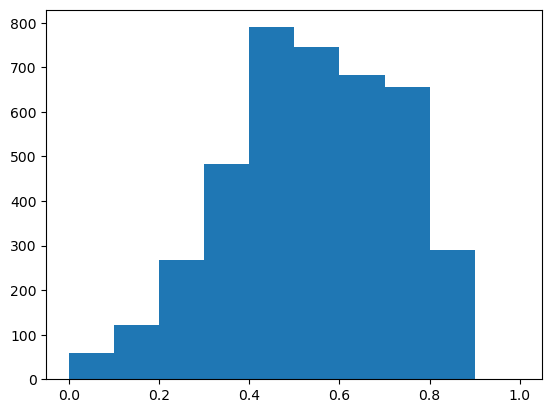

In [36]:
# Plot the frequency of occurrences for the first data point 
plt.hist(X[0], bins=np.arange(0, 1.1, 0.1))

In [13]:
# Ensure all faces are centered
X_centered = X - X.mean(axis=0)

# Apply local centering to ensure features are centered
X_centered -= X_centered.mean(axis=1).reshape(n_samples, -1)

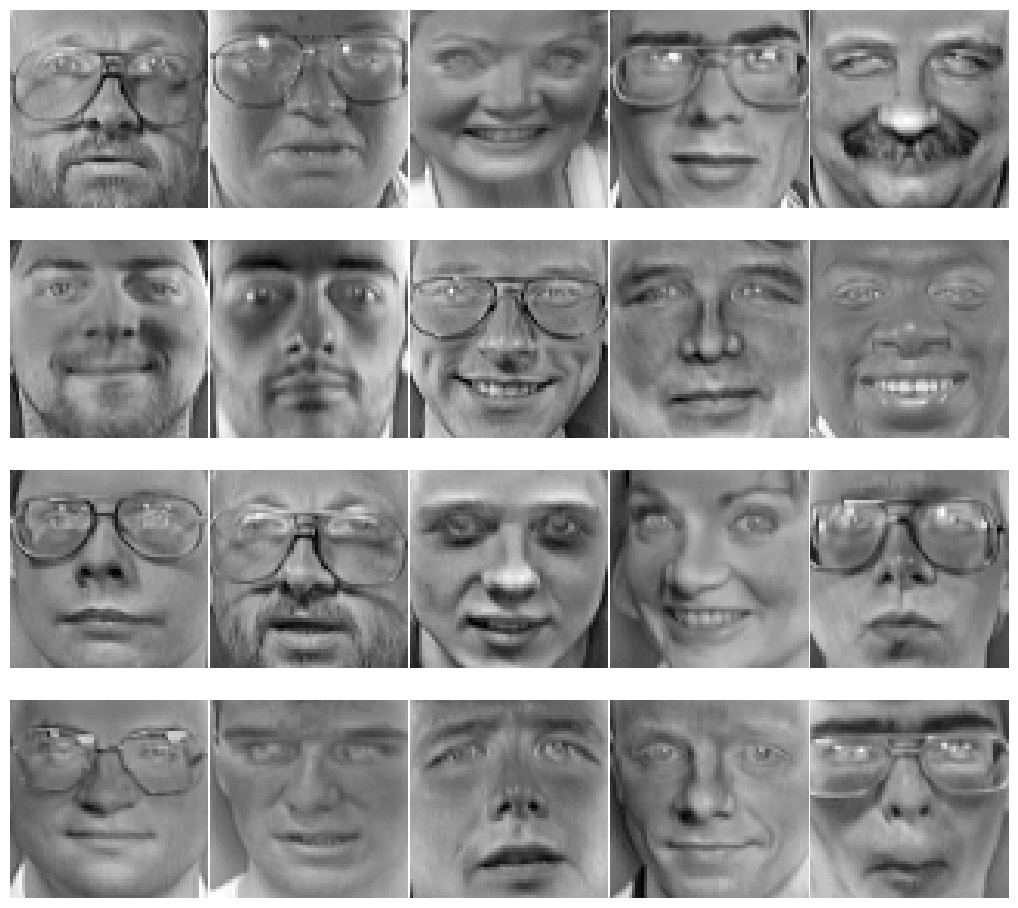

In [28]:
# Plot 20 faces

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10, 9.2), facecolor="white", constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
fig.set_edgecolor("black")

for ax, vec in zip(axs.flat, X_centered[:20]):
    vmax = max(vec.max(), -vec.min())
    ax.imshow(vec.reshape((64, 64)), cmap=plt.cm.gray, interpolation="nearest", vmin=-vmax, vmax=vmax)
    ax.axis("off")

plt.show()

(array([   4.,   37.,  238.,  624., 1068., 1127.,  872.,  123.,    3.,
           0.]),
 array([-5.00000000e-01, -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -1.11022302e-16,  1.00000000e-01,  2.00000000e-01,
         3.00000000e-01,  4.00000000e-01,  5.00000000e-01]),
 <BarContainer object of 10 artists>)

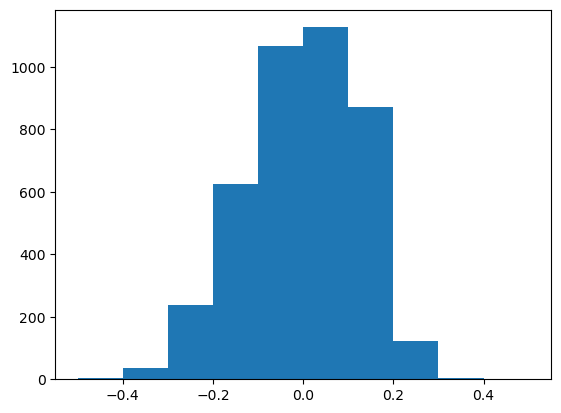

In [40]:
# Plot the frequency of occurrences for the first data point of the centered faces
plt.hist(X_centered[0], bins=np.arange(-.5, .6, 0.1))

In [70]:
# Split test/training using stratified sampling, train an SVM model with it, and score the model

# Initialize a random forest classifier to train the faces with
forest = RandomForestClassifier(n_estimators=40)

# We're using StratifiedShuffleSplit here, which is a merge of StratifiedKFold and ShuffleSplit to prevent as much bias as possible.
# Opted for a 30% test size as we have 10 samples of each person. This way we have 7 faces for training and 3 for testing for each person.
# We're using 10 splits for the same reason - we have 10 samples of each person.
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

confusion_matrices = []

n = 1
for train_idx, test_idx in sss.split(X_centered, y):
    X_train = X_centered[train_idx]
    y_train = y[train_idx]
    X_test = X_centered[test_idx]
    y_test = y[test_idx]
    
    forest.fit(X_train, y_train)
    if n == 3:
        # Export the first tree
        export_graphviz(forest.estimators_[0], out_file='n3_first_tree.dot', proportion=False, precision=3, filled=True)
    
    print(f"--- Split #{n} ---")
    print(f"> Accuracy on training set: {forest.score(X_train, y_train)}")
    print(f"> Accuracy on testing set: {forest.score(X_test, y_test)}")

    print("> Confusion matrix:")
    confusion_matrices.append(confusion_matrix(y_test, forest.predict(X_test)))
    print(confusion_matrices[-1])
    
    n += 1

--- Split #1 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.95
> Confusion matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]
--- Split #2 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.9
> Confusion matrix:
[[2 0 0 ... 1 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]
--- Split #3 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.85
> Confusion matrix:
[[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]
--- Split #4 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.9
> Confusion matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]
--- Split #5 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.9416666666666667
> Confusion matrix:
[[3

Text(50.722222222222214, 0.5, 'Predicted')

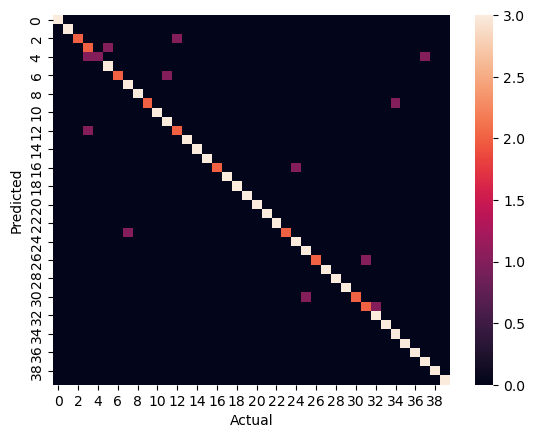

In [48]:
# Plot a heat map of the third confusion matrix
ax = sns.heatmap(confusion_matrices[2])
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

In [16]:
# Alternatively, using the cross_val_score function:
cross_val_score(forest, X_centered, y, cv=sss)

array([0.95      , 0.90833333, 0.90833333, 0.85833333, 0.90833333,
       0.95      , 0.825     , 0.90833333, 0.90833333, 0.89166667])

In [17]:
# Determine the silhouette scores for all possible number of clusters for this dataset
silhouette_scores = {}
for n_clusters in range(2, 401):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=20, max_iter=300, random_state=0)
    labels = kmeans.fit_predict(X_centered)
    score = silhouette_score(X_centered, labels)
    silhouette_scores[n_clusters] = score
    print(f"{n_clusters} clusters -> silhouette score: {score}")

2 clusters -> silhouette score: 0.09744375944137573
3 clusters -> silhouette score: -0.01838238164782524
4 clusters -> silhouette score: 0.0748133435845375
5 clusters -> silhouette score: 0.06625184416770935
6 clusters -> silhouette score: 0.0543549619615078
7 clusters -> silhouette score: 0.05055292695760727
8 clusters -> silhouette score: 0.06535636633634567
9 clusters -> silhouette score: 0.053501058369874954
10 clusters -> silhouette score: 0.036040447652339935
11 clusters -> silhouette score: 0.02956533432006836
12 clusters -> silhouette score: 0.01967967115342617
13 clusters -> silhouette score: 0.04798999801278114
14 clusters -> silhouette score: 0.03478502854704857
15 clusters -> silhouette score: -0.005187415052205324
16 clusters -> silhouette score: -0.02637413516640663
17 clusters -> silhouette score: 0.04510239511728287
18 clusters -> silhouette score: -0.0004810701357200742
19 clusters -> silhouette score: 0.021226994693279266
20 clusters -> silhouette score: 0.03989855945

In [18]:
# Sort the silhouette scores to select the best silhouette score
sorted_silhouette_scores = dict(sorted(silhouette_scores.items(), key=lambda x: x[1]))
sorted_silhouette_scores

{16: -0.026374135,
 26: -0.025442924,
 3: -0.018382382,
 37: -0.0155878095,
 15: -0.005187415,
 18: -0.00048107014,
 399: 0.011404056,
 395: 0.014385047,
 398: 0.015275115,
 400: 0.018923987,
 53: 0.019588226,
 12: 0.019679671,
 397: 0.020097757,
 19: 0.021226995,
 396: 0.021281052,
 392: 0.02156819,
 32: 0.023226567,
 393: 0.024983281,
 25: 0.027047282,
 29: 0.028790297,
 390: 0.029073423,
 21: 0.029291874,
 11: 0.029565334,
 391: 0.029778676,
 389: 0.03260459,
 376: 0.03303456,
 387: 0.03338003,
 28: 0.033769727,
 31: 0.034107696,
 108: 0.034649268,
 14: 0.03478503,
 382: 0.03580649,
 10: 0.036040448,
 22: 0.037555836,
 394: 0.037686106,
 386: 0.03788199,
 366: 0.038935505,
 383: 0.0389446,
 381: 0.03911268,
 388: 0.039654303,
 375: 0.039767932,
 345: 0.039821845,
 358: 0.039892025,
 20: 0.03989856,
 34: 0.040278636,
 369: 0.04044761,
 384: 0.041142836,
 23: 0.04127108,
 380: 0.041367978,
 39: 0.042054232,
 356: 0.042688232,
 88: 0.042927667,
 52: 0.043167427,
 374: 0.043570213,
 35:

In [20]:
# Put the best number of clusters according to silhouette scores in a variable to use later on
best_n_clusters = list(sorted_silhouette_scores.keys())[-1]
best_n_clusters

# One might expect the best number of clusters to be 40 as there are 40 different people in the dataset,
# but one should also consider that the same person can look quite different depending on the angle of the picture, glasses, etc.

186

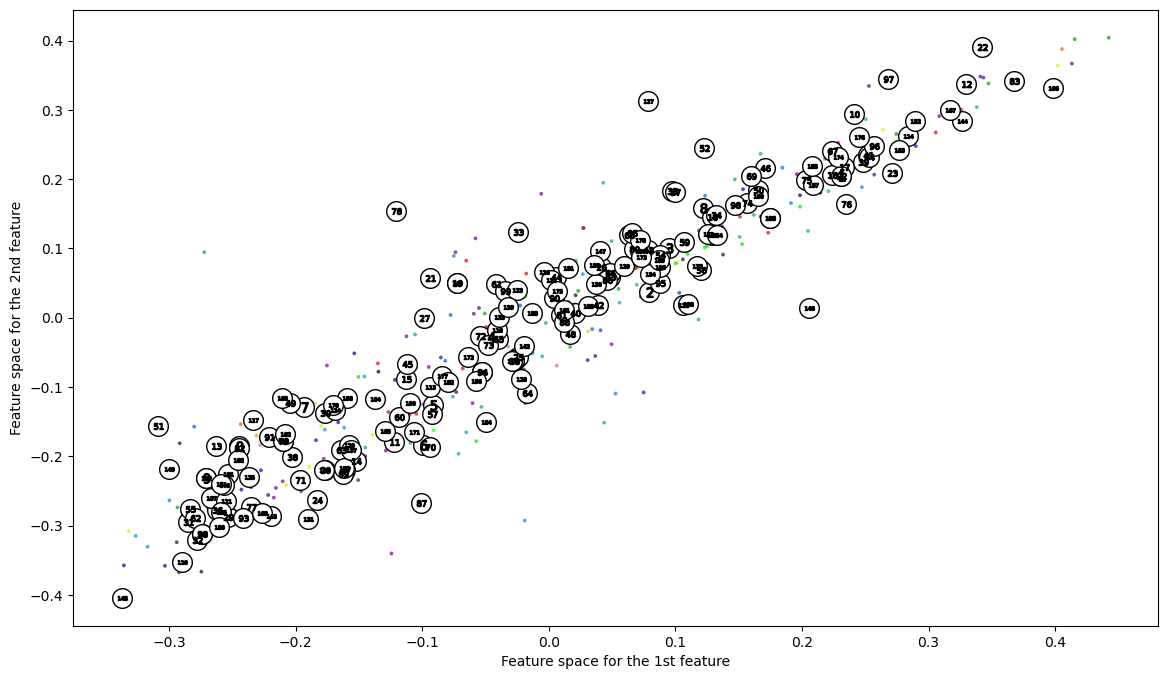

In [61]:
def plot_cluster(n_clusters):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(14, 8)

    clusterer = MiniBatchKMeans(n_clusters=best_n_clusters, batch_size=20, random_state=0)
    cluster_labels = clusterer.fit_predict(X_centered)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax1.scatter(
        X_centered[:, 0], X_centered[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax1.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax1.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

    ax1.set_xlabel("Feature space for the 1st feature")
    ax1.set_ylabel("Feature space for the 2nd feature")

plot_cluster(best_n_clusters)

In [21]:
# Create the model as a pipeline
pipeline = Pipeline([
    ("kmeans", MiniBatchKMeans(n_clusters=best_n_clusters, batch_size=20, random_state=0)),
    ("forest", RandomForestClassifier(n_estimators=40))
])

pipeline

Pipeline(steps=[('kmeans',
                 MiniBatchKMeans(batch_size=20, n_clusters=186,
                                 random_state=0)),
                ('forest', RandomForestClassifier(n_estimators=40))])

In [64]:
# Once again select 10 splits for K-Fold Cross Validation
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

confusion_matrices = []

n = 1
for train_idx, test_idx in sss.split(X_centered, y):
    X_train = X_centered[train_idx]
    y_train = y[train_idx]
    X_test = X_centered[test_idx]
    y_test = y[test_idx]
    
    pipeline.fit(X_train, y_train)
    
    print(f"--- Split #{n} ---")
    print(f"> Accuracy on training set: {pipeline.score(X_train, y_train)}")
    print(f"> Accuracy on testing set: {pipeline.score(X_test, y_test)}")

    print("> Confusion matrix:")
    confusion_matrices.append(confusion_matrix(y_test, pipeline.predict(X_test)))
    print(confusion_matrices[-1])
    
    n += 1

--- Split #1 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.7916666666666666
> Confusion matrix:
[[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]
--- Split #2 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.7333333333333333
> Confusion matrix:
[[1 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 1 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
--- Split #3 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.8333333333333334
> Confusion matrix:
[[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 1 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]
--- Split #4 ---
> Accuracy on training set: 1.0
> Accuracy on testing set: 0.7583333333333333
> Confusion matrix:
[[1 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 2]]
--- Split #5 ---
> Accuracy on training set: 1.0
> Accuracy 

Text(50.722222222222214, 0.5, 'Predicted')

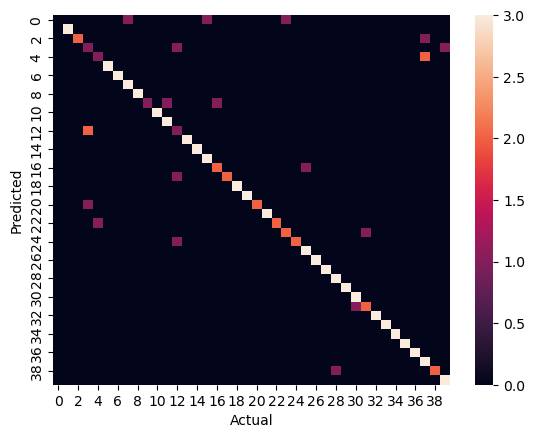

In [65]:
# Plot a heat map of the third confusion matrix again, but this time of the pipeline
ax = sns.heatmap(confusion_matrices[2])
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

In [23]:
# Or, alternatively, we can use the cross_val_score function:
cross_val_score(pipeline, X_centered, y, cv=sss)

array([0.79166667, 0.74166667, 0.81666667, 0.8       , 0.85833333,
       0.775     , 0.76666667, 0.78333333, 0.75833333, 0.70833333])

In [24]:
# Select the first training and testing indexes from the K-Fold Cross Validation we did before
train_idx, test_idx = next(StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0).split(X_centered, y))
train_idx, test_idx

(array([289, 372, 120, 102,   7, 283, 198, 100, 320, 357,  89, 181, 364,
        291, 263, 133, 341, 226, 132, 344, 144, 381, 342, 355,  85, 254,
        298,  73, 277, 287,  52,   4,  84,   2,  65, 219, 116, 300, 327,
        128, 176, 301, 156, 349, 179, 164, 262,  59, 371, 143, 260, 232,
        222, 200, 270, 356, 345, 113, 192, 360,  70, 185, 299,  32, 118,
        337,  16,  61,  82, 126, 318, 365, 212,  54, 107,  57,  49, 169,
        191, 378, 307, 273, 187, 367,  50, 377, 351, 268,  40, 294, 115,
        205, 217, 309, 238, 180, 368, 141,  88,  71,  36,  45, 186, 361,
        161, 103,  97, 324, 210, 385, 384, 282, 392,  41,  23, 304, 117,
        397, 390, 221, 257,  79,   8, 109, 166, 267, 105, 124,  47, 244,
        293, 171, 196, 353, 396,  62, 214, 236, 314,  95, 330, 130, 134,
        215, 253,  78,  30,  13,   6, 281,  21, 284,  63, 189, 369, 308,
        125, 264,  55,  56, 160, 272, 296, 274, 208, 239, 163, 218, 193,
        145, 204, 329,  68, 175,  27, 315,  33, 110

In [25]:
# And train the model! :)
pipeline.fit(X_centered[train_idx], y[train_idx])

Pipeline(steps=[('kmeans',
                 MiniBatchKMeans(batch_size=20, n_clusters=186,
                                 random_state=0)),
                ('forest', RandomForestClassifier(n_estimators=40))])

In [26]:
# And save (pickle) the model
joblib.dump(pipeline, './group_project_model.pkl')
print('Model dumped!')

Model dumped!


In [100]:
# For testing purposes: this lets us grab a specific data point as JSON (so that we can use it in Postman)
import json
json.dumps([float(x) for x in X_centered[1]])

'[0.012049693614244461, -0.005522500723600388, -0.006245624274015427, -0.0029917173087596893, -0.002165120095014572, 0.009405393153429031, 0.018031079322099686, 0.012607414275407791, 0.0035684294998645782, -0.016472797840833664, -0.017826002091169357, -0.03658674284815788, -0.0392828993499279, -0.04062638804316521, -0.045904796570539474, -0.041369419544935226, -0.045718830078840256, -0.05809495970606804, -0.06915919482707977, -0.05509905144572258, -0.0737147182226181, -0.04928312823176384, -0.04191730543971062, -0.028466563671827316, -0.015884440392255783, 7.661059498786926e-05, -0.002176206558942795, 0.015964705497026443, -0.0032494477927684784, -0.010274570435285568, -0.035202424973249435, -0.024303477257490158, -0.03317723795771599, -0.04960302636027336, -0.062650665640831, -0.05330149456858635, -0.04891053959727287, -0.05625591799616814, -0.05373547598719597, -0.0545104555785656, -0.05453048273921013, -0.050915103405714035, -0.04689667746424675, -0.054644566029310226, -0.0591691546